In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from surprisal_utils import compute_log_frequency, exclude_token, prev_token_predictors
from analysis_utils import run_crossval, format_logliks
sns.set_theme()
sns.set_palette("colorblind")

# Data Preprocessing

In [13]:
ns_rts = pd.read_table("natural_stories_rts.tsv", sep = "\t")
ns_surprisal = pd.read_table("ns_rnn.tsv", sep = "\t")
ns_tpc = pd.read_csv("natural_stories_metrics_linear_0_512_new.csv")

In [14]:
ns_rts.head()

,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT
0,A3QJPB0NZU5PY1,3960,6,1,1,924,If,84,369.011905,160.579935,340.566023,1.490513
1,A2RPQGUWVZPX7U,2431,5,1,1,474,If,84,369.011905,160.579935,340.566023,1.490513
2,A11KMPAZSE5Q0Q,1287,5,1,1,272,If,84,369.011905,160.579935,340.566023,1.490513
3,A1U1QL617G5DU3,2074,6,1,1,354,If,84,369.011905,160.579935,340.566023,1.490513
4,ACTW5YEWV9OR0,2213,6,1,1,577,If,84,369.011905,160.579935,340.566023,1.490513


In [15]:
ns_surprisal.head()

,word,sentid,sentpos,wlen,surp,entropy,entred
0,If,0,0,2,10.248306,5.634664,0.000000
1,you,0,1,3,7.058940,5.231227,0.403437
2,were,0,2,4,3.672294,7.170536,0.000000
3,to,0,3,2,5.858786,8.976997,0.000000
4,journey,0,4,7,17.379740,7.208412,1.768585


In [16]:
ns_tpc.head()

,Unnamed: 0,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,...,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
0,0,If,369.011905,1.914162,2,0,375.016510,0.880681,5.637548,0.592878,...,0.338693,0.485173,0.258339,0.507138,0.153830,1.002278,0.582389,36.162292,349,if
1,1,you,368.183908,0.987995,3,1,374.975616,0.520381,2.242520,0.199160,...,0.160373,0.379716,0.174865,0.344078,0.229773,0.854273,0.414032,36.139481,330,you
2,2,were,344.318182,1.721557,4,2,374.990692,0.475426,4.293675,0.043788,...,0.130094,0.442103,0.187409,0.442977,0.378069,0.936419,0.265883,36.152298,303,were
3,3,to,354.639535,1.574903,2,3,374.957733,0.429041,4.000612,0.069285,...,0.094578,0.336446,0.101356,0.300196,0.291088,0.917132,0.236109,36.131744,301,to
4,4,journey,349.674157,4.775415,7,4,375.079498,0.446789,4.031974,-0.026358,...,0.143135,0.600270,0.360943,0.670735,0.603879,0.865874,0.191918,36.193527,293,journey


In [17]:
ns_tpc.columns

Index(['Unnamed: 0', 'token', 'RT', 'brown_bigram_surprisal', 'length',
       'index', 'free_energy', 'arclength', 'amplitude', 'li_top_down',
       'li_bottom_up', 'wnorm_xy', 'wnorm_xx', 'bnorm_x', 'bnorm_y',
       'cosdist_y', 'cosdist_prior_v_posterior',
       'cosdist_posterior_v_posterior', 'cosdist_likelihood_v_posterior',
       'bayesian_surprise', 'iters', 'model_token'],
      dtype='object')

In [18]:
len(ns_surprisal.index)

10256

In [19]:
len(ns_tpc.index)

10256

In [20]:
predictor_names = ['rnn_surprisal', 'brown_bigram_surprisal', 'iters', 'arclength',
 'li_bottom_up',
 'li_top_down',
 'free_energy',
 'wnorm_xy',
 'wnorm_xx',
 'cosdist_y',
 'cosdist_prior_v_posterior',
 'cosdist_likelihood_v_posterior',
 'bayesian_surprise']

In [21]:
ns_predictors = ns_tpc.merge(ns_surprisal, right_index=True, left_index=True)
ns_predictors['log_freq'] = ns_predictors['token'].apply(compute_log_frequency, language = "en")
ns_predictors.rename({"wlen" : "word_length", "surp" : "rnn_surprisal"}, axis = 1, inplace=True)

/Users/sathvik/Desktop/umd/predictive-coding/surprisal_utils.py:17: RuntimeWarning: divide by zero encountered in log2
  return -np.log2(freq)


In [22]:
ns_predictors['exclude'] = [exclude_token(ns_predictors, i, 'token') for i in range(len(ns_predictors.index))]

In [24]:
ns_predictors = ns_predictors[(ns_predictors['exclude'] == 0)]
ns_predictors.replace([np.inf, -np.inf], np.nan, inplace=True)
ns_predictors = ns_predictors.dropna()

In [25]:
len(ns_predictors.index)

6619

# Computing Psychometric Predictive Power

In [80]:
np.random.seed(84)

In [81]:
cv = KFold(n_splits=10, shuffle=True)
cv_split = cv.split(np.array(ns_predictors))
indices = []
for train_indices, test_indices in cv_split:
    indices.append((train_indices, test_indices))

In [82]:
gam_ppp = run_crossval(indices, ns_predictors, predictor_names, 0, is_linear = False)

Running 10-fold CV for rnn_surprisal
Average Delta LogLik: 0.0035091638703296014
Running 10-fold CV for brown_bigram_surprisal
Average Delta LogLik: 0.004517030946422728
Running 10-fold CV for iters
Average Delta LogLik: 0.007479089563421759
Running 10-fold CV for arclength
Average Delta LogLik: 0.008909772974435626
Running 10-fold CV for li_bottom_up
Average Delta LogLik: 0.0010347737666545065
Running 10-fold CV for li_top_down
Average Delta LogLik: 0.012085724999533287
Running 10-fold CV for free_energy
Average Delta LogLik: 0.00288930720061602
Running 10-fold CV for wnorm_xy
Average Delta LogLik: 0.005076063096995575
Running 10-fold CV for wnorm_xx
Average Delta LogLik: 0.014087340907930823
Running 10-fold CV for cosdist_y
Average Delta LogLik: 0.0026888692620925525
Running 10-fold CV for cosdist_prior_v_posterior
Average Delta LogLik: 0.0023936276933390842
Running 10-fold CV for cosdist_likelihood_v_posterior
Average Delta LogLik: 0.006076021487457251
Running 10-fold CV for bayesia

In [83]:
tpc_delta_loglik = pd.DataFrame(gam_ppp)

melted_loglik = format_logliks(tpc_delta_loglik)

Text(0.5, 1.0, 'Psychometric Predictive Power (Natural Stories)')

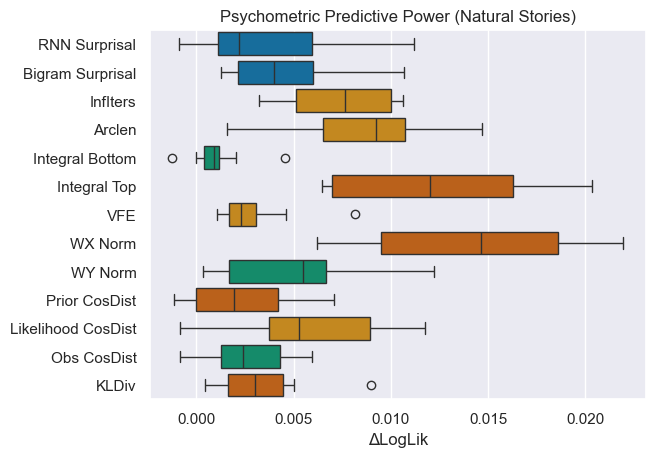

In [84]:
sns.boxplot(data = melted_loglik, x = "value", y = "predictor_name", hue = "metric_type", legend=False,
            order=["RNN Surprisal", "Bigram Surprisal",
                   "InfIters", "Arclen", "Integral Bottom", "Integral Top", "VFE", "WX Norm",
                   "WY Norm", "Prior CosDist", "Likelihood CosDist", "Obs CosDist", "KLDiv"])
plt.xlabel("ΔLogLik")
plt.ylabel("")
plt.title("Psychometric Predictive Power (Natural Stories)")

# Statistical Tests

In [90]:
from analysis_utils import significance_table, compare_with_surprisal, significance_surprisal

In [94]:
significance_table(tpc_delta_loglik)

,predictor_name,stat,p_value,significance
0,rnn_surprisal,53.0,0.002930,**
1,brown_bigram_surprisal,55.0,0.000977,***
2,iters,55.0,0.000977,***
3,arclength,55.0,0.000977,***
4,li_bottom_up,46.0,0.032227,*
5,li_top_down,55.0,0.000977,***
6,free_energy,55.0,0.000977,***
7,wnorm_xy,55.0,0.000977,***
8,wnorm_xx,55.0,0.000977,***
9,cosdist_y,54.0,0.001953,**


Checking for whether a predictor was better than surprisal

In [89]:
tpc_predictors = predictor_names[2:]

vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors, "greater")

significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,49.0,0.013672,*
1,arclength,50.0,0.009766,**
2,li_bottom_up,12.0,0.947266,None
3,li_top_down,54.0,0.001953,**
4,free_energy,28.0,0.500000,None
5,wnorm_xy,41.0,0.096680,None
6,wnorm_xx,55.0,0.000977,***
7,cosdist_y,23.0,0.687500,None
8,cosdist_prior_v_posterior,27.0,0.539062,None
9,cosdist_likelihood_v_posterior,43.0,0.065430,None


In [95]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,44.0,0.052734,None
1,arclength,47.0,0.024414,*
2,li_bottom_up,0.0,1.000000,None
3,li_top_down,54.0,0.001953,**
4,free_energy,16.0,0.883789,None
5,wnorm_xy,29.0,0.460938,None
6,wnorm_xx,55.0,0.000977,***
7,cosdist_y,18.0,0.838867,None
8,cosdist_prior_v_posterior,14.0,0.919922,None
9,cosdist_likelihood_v_posterior,39.0,0.137695,None


Seeing which predictors were comparable with surprisal

In [99]:
vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors)
significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,6.0,0.027344,*
1,arclength,5.0,0.019531,*
2,li_bottom_up,12.0,0.130859,None
3,li_top_down,1.0,0.003906,**
4,free_energy,27.0,1.000000,None
5,wnorm_xy,14.0,0.193359,None
6,wnorm_xx,0.0,0.001953,**
7,cosdist_y,23.0,0.695312,None
8,cosdist_prior_v_posterior,27.0,1.000000,None
9,cosdist_likelihood_v_posterior,12.0,0.130859,None


In [98]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,11.0,0.105469,None
1,arclength,8.0,0.048828,*
2,li_bottom_up,0.0,0.001953,**
3,li_top_down,1.0,0.003906,**
4,free_energy,16.0,0.275391,None
5,wnorm_xy,26.0,0.921875,None
6,wnorm_xx,0.0,0.001953,**
7,cosdist_y,18.0,0.375000,None
8,cosdist_prior_v_posterior,14.0,0.193359,None
9,cosdist_likelihood_v_posterior,16.0,0.275391,None


In [59]:
def fit_gam(df : pd.DataFrame, predictor_name : str, num_spillover : int,
                     return_predictors : bool, linear : bool, baseline : bool):
    predictors = []
    predictors += [predictor_name] + [f'prev_{predictor_name}_{i}' for i in range(1, num_spillover + 1)]
    predictors += ['word_length', 'log_freq'] + \
        np.array([[f'prev_len_{i}', f'prev_freq_{i}'] for i in range(1, num_spillover + 1)]).flatten().tolist()
    # the features are based on the indices of the predictors
    rt_column = 'RT'
    model_data = df[predictors + [rt_column]].dropna()
    standardizer = StandardScaler()
    X = standardizer.fit_transform(np.array(model_data[predictors]))
    y = np.array(model_data[rt_column])
    terms = build_TermList(baseline, num_spillover, linear)
    if linear:
        gam = LinearGAM(terms)
    else:
        gam = GAM(terms)
    gam.fit(X, y)
    if return_predictors:
        return gam, predictors
    return gam


Fitting model for free_energy
Fitting model for cosdist_y
Fitting model for rnn_surprisal
Fitting model for brown_bigram_surprisal


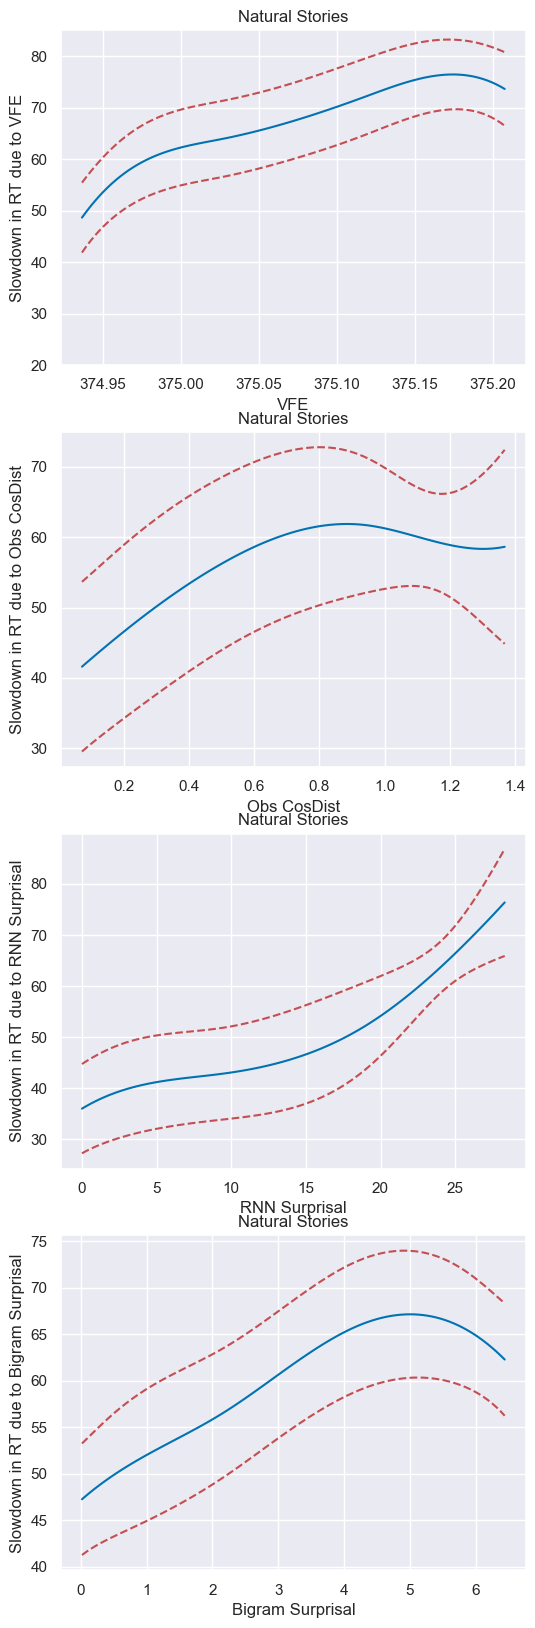

In [ ]:
surprisal_like = ['free_energy', 'cosdist_y', 'rnn_surprisal', 'brown_bigram_surprisal']
plot_labels = ["VFE", "Obs CosDist", 'RNN Surprisal', "Bigram Surprisal"]
bounds = [(20, 85), (None, None), (None, None), (None, None)]

fig, axs = plt.subplots(len(surprisal_like), figsize = (6, 20), sharex=False)
for i in range(len(surprisal_like)):
    predictor = surprisal_like[i]
    print(f"Fitting model for {predictor}")
    model = fit_gam(ns_predictors, predictor, 0, False, False, False)
    plot_gam(model, ns_predictors[predictor], plot_labels[i], axs[i], bounds[i])
